In [ ]:
!pip install scikit-image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
# Simple AI agent handling preprocessing and inference
class PotatoLeafAIAgent:
    def __init__(self, scaler=None, class_map=None, img_size=(224,224)):
        self.scaler = scaler
        self.class_map = class_map
        self.img_size = img_size

    def remove_background(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        result = cv2.bitwise_and(image, image, mask=mask)
        return result

    def edge_map(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        return edges

    def extract_features(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=cv2.contourArea) if contours else None
        area = cv2.contourArea(cnt) if cnt is not None else 0
        perimeter = cv2.arcLength(cnt, True) if cnt is not None else 0

        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mean_hue = np.mean(hsv[:,:,0])
        mean_sat = np.mean(hsv[:,:,1])
        mean_val = np.mean(hsv[:,:,2])

        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, 'uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_feature = hist

        glcm = graycomatrix(gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]

        features = [area, perimeter, mean_hue, mean_sat, mean_val, contrast, homogeneity, energy]
        features = np.concatenate([features, lbp_feature])
        return features

    def preprocess_image(self, path):
        image = cv2.imread(path)
        image = cv2.resize(image, self.img_size)
        img_bg = self.remove_background(image)
        edge = self.edge_map(img_bg)
        features = self.extract_features(img_bg)
        img_norm = img_bg.astype('float32') / 255.0
        edge_norm = np.expand_dims(edge, axis=-1) / 255.0
        return img_norm, features, edge_norm

    def prepare_single_sample(self, path):
        img, feat, edg = self.preprocess_image(path)
        combined_img = np.concatenate([img, edg], axis=-1)
        if self.scaler is not None:
            feat_scaled = self.scaler.transform([feat])
        else:
            feat_scaled = np.array([feat])
        return np.expand_dims(combined_img, axis=0), feat_scaled

    def predict(self, model, img_path):
        Ximg, Xfeat = self.prepare_single_sample(img_path)
        pred = model.predict([Ximg, Xfeat])
        if self.class_map:
            return list(self.class_map.keys())[np.argmax(pred)]
        return np.argmax(pred)


In [ ]:
dataset_path = '/content/drive/MyDrive/MCA Sem 1 ML Project/train'
img_size = (224, 224)
max_images_per_class = 1000

images, edges, features, labels = [], [], [], []

class_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
class_map = {cls: i for i, cls in enumerate(class_folders)}
agent = PotatoLeafAIAgent(img_size=img_size)

for cls in class_folders:
    cls_folder = os.path.join(dataset_path, cls)
    img_files = [f for f in os.listdir(cls_folder) if os.path.isfile(os.path.join(cls_folder, f))]
    selected_files = random.sample(img_files, min(max_images_per_class, len(img_files)))
    for fname in selected_files:
        fpath = os.path.join(cls_folder, fname)
        try:
            img, feat, edg = agent.preprocess_image(fpath)
            images.append(img)
            edges.append(edg)
            features.append(feat)
            labels.append(class_map[cls])
        except:
            print(f"Failed to process {fpath}, skipping.")

images = np.array(images)
edges = np.array(edges)
features = np.array(features)
labels = np.array(labels)


In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

combined_images = np.concatenate([images, edges], axis=-1)
labels_cat = to_categorical(labels, num_classes=len(class_map))

X_train_img, X_test_img, X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    combined_images, features_scaled, labels_cat, test_size=0.2, random_state=42
)

# Update agent with fitted scaler and classes
agent.scaler = scaler
agent.class_map = class_map


In [ ]:
np.save('images.npy', images)
np.save('edges.npy', edges)
np.save('features.npy', features)
np.save('labels.npy', labels)
np.save('features_scaled.npy', features_scaled)
np.save('combined_images.npy', combined_images)
np.save('labels_cat.npy', labels_cat)

np.savez_compressed('potato_leaves_preprocessed.npz',
                    images=images, edges=edges, features=features,
                    labels=labels, features_scaled=features_scaled,
                    combined_images=combined_images, labels_cat=labels_cat)


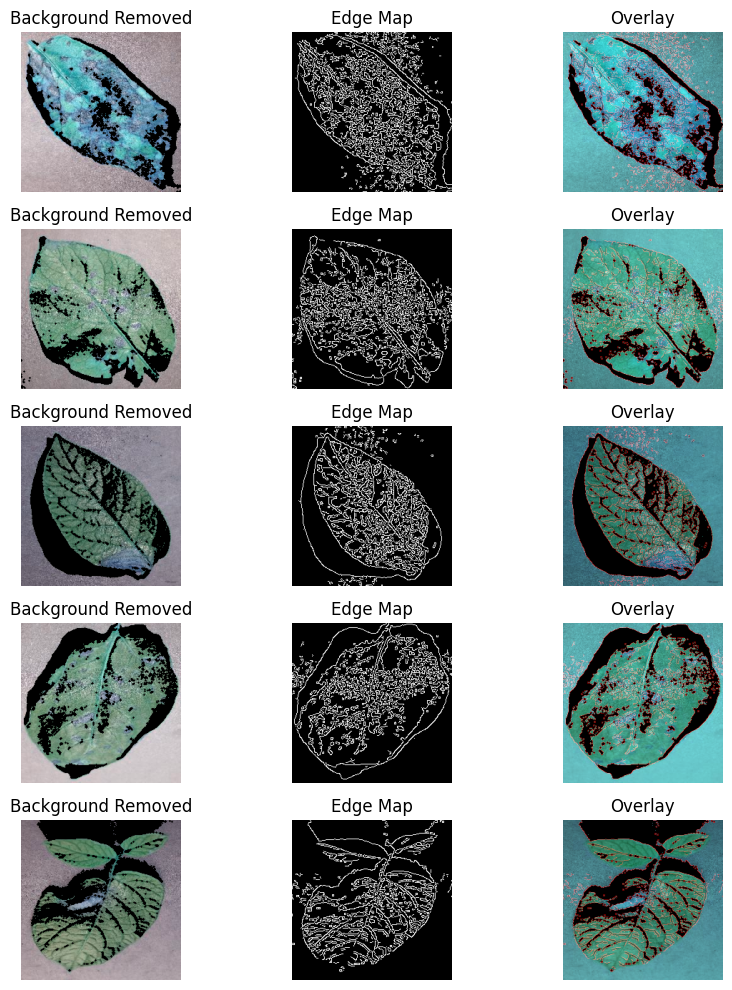

In [ ]:
n = 5
fig, axes = plt.subplots(n, 3, figsize=(9, 2 * n))
for i in range(n):
    idx = random.randint(0, len(images)-1)
    axes[i,0].imshow(images[idx])
    axes[i,0].set_title('Background Removed')
    axes[i,1].imshow(edges[idx].squeeze(), cmap='gray')
    axes[i,1].set_title('Edge Map')
    overlay = images[idx].copy()
    overlay[:,:,0] = np.clip(overlay[:,:,0]*0.5 + edges[idx].squeeze()*0.5, 0, 1)
    axes[i,2].imshow(overlay)
    axes[i,2].set_title('Overlay')
    for j in range(3): axes[i,j].axis('off')
plt.tight_layout()
plt.show()


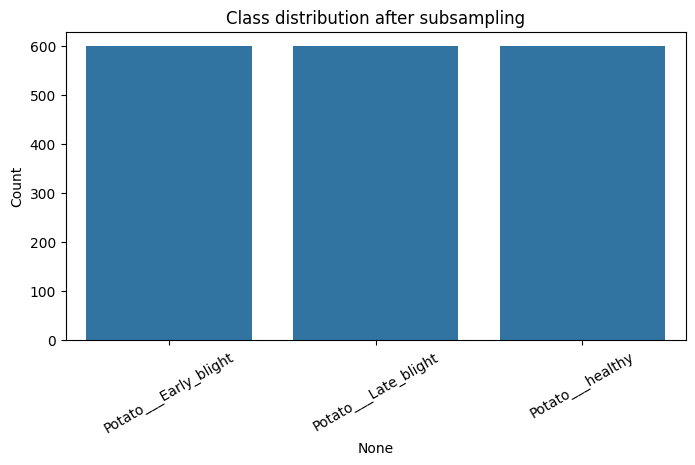

In [ ]:
import seaborn as sns
class_names = list(class_map.keys())
class_counts = pd.Series(labels).map(dict(zip(range(len(class_names)), class_names))).value_counts()
plt.figure(figsize=(8,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=30)
plt.title('Class distribution after subsampling')
plt.ylabel('Count')
plt.show()


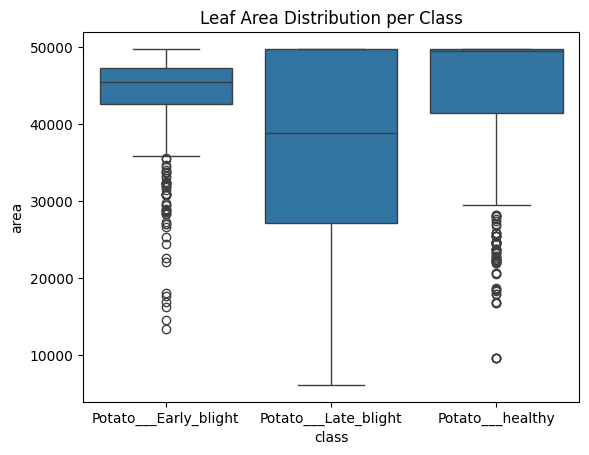

In [ ]:
feat_df = pd.DataFrame(features, columns=[
    'area','perimeter','mean_hue','mean_sat','mean_val',
    'contrast','homogeneity','energy'] + [f'lbp_{i}' for i in range(features.shape[1]-8)])
feat_df['class'] = pd.Series(labels).map(dict(zip(range(len(class_names)), class_names)))
sns.boxplot(data=feat_df, x='class', y='area')
plt.title('Leaf Area Distribution per Class')
plt.show()


In [ ]:
cnn_input = Input(shape=(img_size[0], img_size[1], 4))
feat_input = Input(shape=(features_scaled.shape[1],))

base = MobileNetV2(include_top=False, weights=None, input_tensor=cnn_input)
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Concatenate()([x, feat_input])
output = Dense(len(class_map), activation='softmax')(x)

model = Model([cnn_input, feat_input], output)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    [X_train_img, X_train_feat], y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=16,
    callbacks=[reduce_lr]
)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - accuracy: 0.5120 - loss: 1.0360 - val_accuracy: 0.5417 - val_loss: 0.9968 - learning_rate: 1.0000e-04
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 415ms/step - accuracy: 0.5808 - loss: 0.9861 - val_accuracy: 0.6319 - val_loss: 0.9504 - learning_rate: 1.0000e-04
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - accuracy: 0.6427 - loss: 0.9346 - val_accuracy: 0.6250 - val_loss: 0.9147 - learning_rate: 1.0000e-04
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 429ms/step - accuracy: 0.6359 - loss: 0.8983 - val_accuracy: 0.6319 - val_loss: 0.8871 - learning_rate: 1.0000e-04
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 412ms/step - accuracy: 0.6619 - loss: 0.8791 - val_accuracy: 0.6458 - val_loss: 0.8643 - learning_rate: 1.0000e-04
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 430ms/step - accuracy: 0.6524 - loss: 0.8514 - val_accuracy: 0.6597 - val_loss: 0.8450 - learning_rate: 1.0000e-04
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 448ms/step - acc

In [ ]:
model.save('potato_leaf_classifier.h5')


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 942ms/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.75      0.81      0.78       127
 Potato___Late_blight       0.74      0.69      0.71       105
     Potato___healthy       0.74      0.73      0.74       128

             accuracy                           0.74       360
            macro avg       0.74      0.74      0.74       360
         weighted avg       0.74      0.74      0.74       360



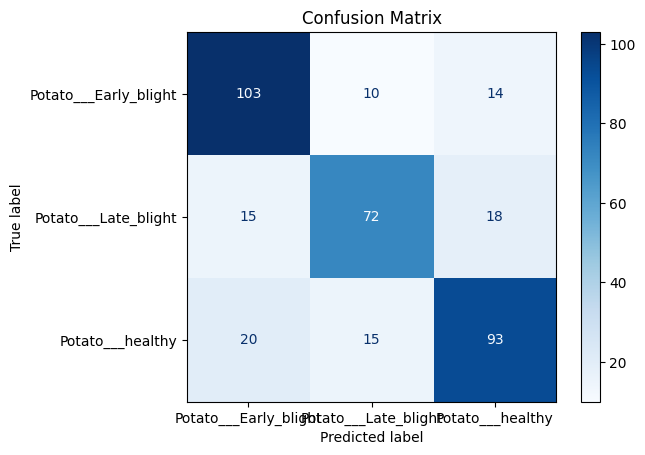

In [ ]:
y_true = np.argmax(y_test, axis=1)
y_pred_prob = model.predict([X_test_img, X_test_feat])
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_true, y_pred, target_names=class_map.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_map.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


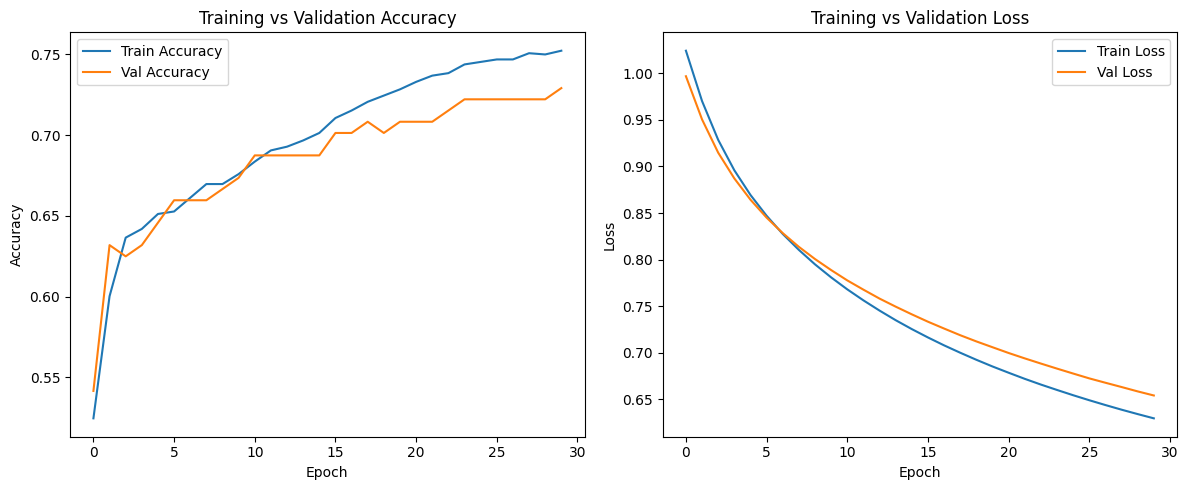

In [ ]:
# Accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.tight_layout()
plt.show()
